## Import libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

### Read Routes and Incidents Datasets

In [9]:
routes_df=pd.read_csv("../Files/ShippingRoutes.csv")
incidents_df=pd.read_csv("../Files/ShippingIncident.csv")

##### Top Five records

### Drop columns (returns a new DataFrame)

In [7]:
columns_to_drop = ['Route_Id',	'Origin_Port',	'Destination_Port'	,'Orgin_Port_Country','Travel_Direction','Destination_Port_Country','No_Of_Stops','Stops_Names',	'Stop_Points','Vessel_Type'		]  

new_df_routes = routes_df.drop(columns=columns_to_drop)
new_df_routes.head()

,Distance,Average_Transit_Days,No_Of_Travels,Total_Incidents_Count,High,Last_5Months_High,Last_10Days_High,Medium,Last_5Months_Medium,Last_10Days_Medium,Low,Last_5Months_Low,Last_10Days_Low,Risk_Score
0,600,18,5000,132,2,0,0,3,0,0,116,6,5,7
1,2468,29,4500,122,3,0,0,1,0,0,90,18,10,7
2,3457,39,5500,125,2,1,1,1,1,6,92,15,6,7
3,4500,15,6000,111,5,0,0,1,0,0,86,17,2,5
4,200,27,5000,131,2,0,0,3,0,0,113,7,6,10


# Import Seaborn


c:\Users\jegadeesan.rameshbab\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


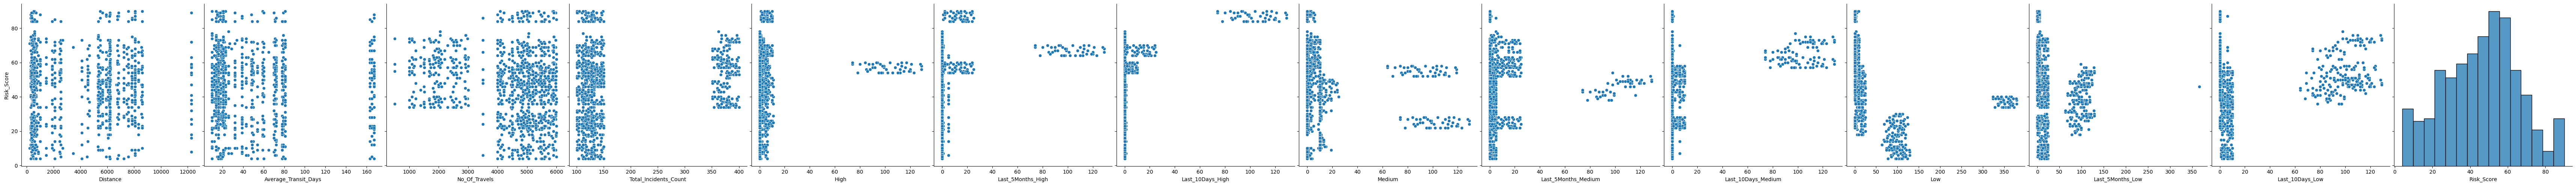

In [9]:

sns.pairplot(new_df_routes, x_vars = ['Distance','Average_Transit_Days','No_Of_Travels','Total_Incidents_Count','High','Last_5Months_High','Last_10Days_High','Medium','Last_5Months_Medium','Last_10Days_Medium'	,'Low','Last_5Months_Low','Last_10Days_Low','Risk_Score'],
             
             y_vars = 'Risk_Score', size = 5, kind = 'scatter')

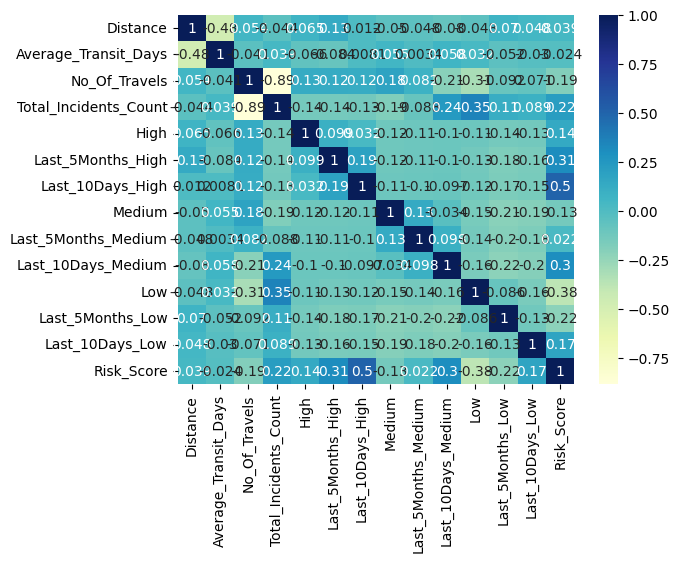

In [10]:
sns.heatmap(new_df_routes.corr(), cmap = "YlGnBu", annot = True)
plt.show()

### Split data into features and target variable

In [11]:

X = new_df_routes.drop(columns=['Risk_Score'])
y = new_df_routes['Risk_Score']

### Split data into training and testing sets

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Create and train the model

In [ ]:

model = LinearRegression()
model.fit(X_train, y_train)



#### Make predictions


y_pred = model.predict(X_test)



#### Evaluate the model


In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



#### Display the first few predictions


In [ ]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_df.head())

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)



#### Evaluating models


In [ ]:
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest Mean Squared Error: {rf_mse}')




#### Display the first few predictions


In [ ]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': rf_predictions})
print(predictions_df.head())

#### Create a Pandas Series to store the predicted scores


In [ ]:
predicted_scores_series = pd.Series(predicted_scores, index=new_data.index, name='Predicted_Risk_Score')

print(predicted_scores_series)

#### Serialize the model to a file


In [ ]:
with open('risk_model.pkl', 'wb') as f:
    pickle.dump(model, f)

#### Serialize the model to a file


In [ ]:
with open('risk_randomforest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)